# Step-1: Business Problem

- Can we accurately forecast Netflix's stock price movements to help investors and analysts make informed trading decisions?

**Use Case & Importance:**

1.Stock market investors and financial analysts need reliable forecasts to make better trading decisions. Predicting stock price trends can help:

2.Investors: Optimize buy/sell strategies based on predicted stock movements.

3.Hedge Funds & Traders: Identify short-term price fluctuations for profitable trades.

4Financial Analysts: Assess market trends and develop investment strategies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\divya\Downloads\Netflix Dataset.csv")
df

,Date,Close
0,23-05-2002,1.196429
1,24-05-2002,1.210000
2,28-05-2002,1.157143
3,29-05-2002,1.103571
4,30-05-2002,1.071429
...,...,...
5535,20-05-2024,640.820007
5536,21-05-2024,650.609985
5537,22-05-2024,640.469971
5538,23-05-2024,635.669983


 **Data Preprocessing**

In [6]:
# Convert the 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

# Set 'Date' as index
df.set_index("Date", inplace=True)

# Sort by date (important for time series)
df.sort_index(inplace=True)


In [8]:
print(df.info())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5540 entries, 2002-05-23 to 2024-05-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5540 non-null   float64
dtypes: float64(1)
memory usage: 86.6 KB
None


In [10]:
df.head()

,Close
Date,
2002-05-23,1.196429
2002-05-24,1.210000
2002-05-28,1.157143
2002-05-29,1.103571
2002-05-30,1.071429


In [12]:
df.describe()

,Close
count,5540.000000
mean,140.561354
std,182.376297
min,0.372857
25%,4.163036
50%,36.154285
75%,282.892502
max,691.690002


**EDA & Visualize the time Series**

**check for trend, seasonality or random patterns**

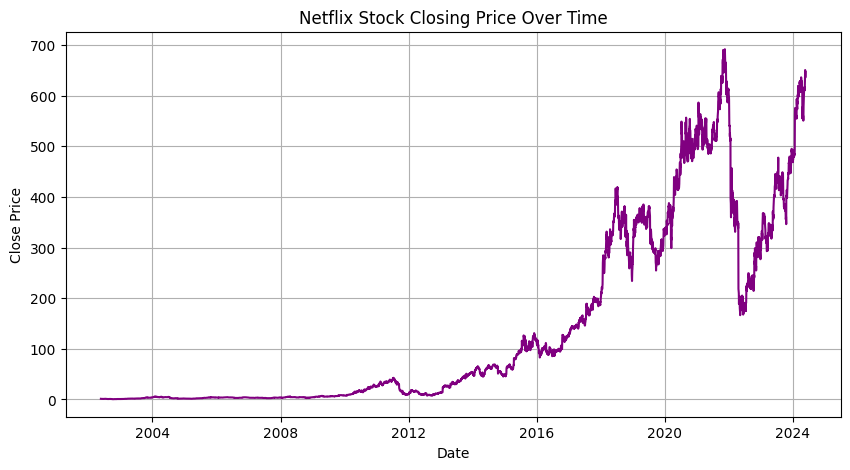

In [15]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df['Close'], color='purple')
plt.title('Netflix Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

**Check for stationarity**

**Method-1: Rolling Statistics**

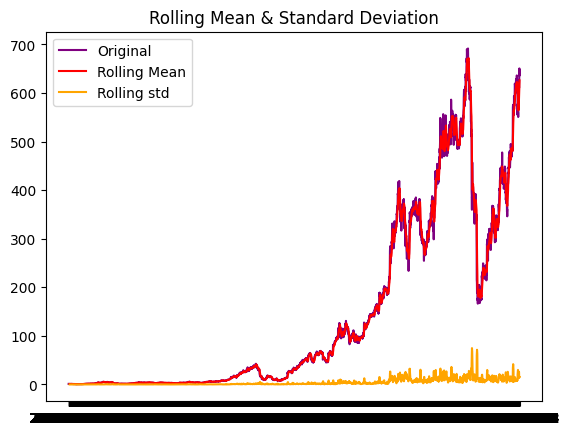

In [18]:
# Determing rolling statistics
rolmean = df['Close'].rolling(window=12).mean()
rolstd = df['Close'].rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df['Close'], color = 'purple' , label = 'Original')
mean = plt.plot(rolmean, color = 'red', label='Rolling Mean')
std = plt.plot(rolstd, color = 'Orange', label = "Rolling std")
plt.title("Rolling Mean & Standard Deviation")
plt.xticks(ticks=df.index)
plt.legend()
plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller
adfuller_result = adfuller(df['Close'])
adfuller_result

(0.08796313459767399,
 0.9652296074117495,
 33,
 5506,
 {'1%': -3.4315382221747797,
  '5%': -2.8620650763349165,
  '10%': -2.567049496943466},
 35289.26155134436)

In [22]:
print('p-value:',adfuller_result[1])

p-value: 0.9652296074117495


In [24]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: 0.08796313459767399
p-value: 0.9652296074117495


In [26]:
diff = df['Close'] - df['Close'].shift(1)

diff.dropna(inplace=True)

#Check whether the data is stationary or not after applying differencing
adfuller_result = adfuller(diff)
print('p-value of adf test:',adfuller_result[1])

p-value of adf test: 4.352157892206304e-22


In [28]:
diff.dropna(inplace=True)

In [30]:
adfuller_result = adfuller(diff)
adfuller_result

(-11.94942351229549,
 4.352157892206304e-22,
 32,
 5506,
 {'1%': -3.4315382221747797,
  '5%': -2.8620650763349165,
  '10%': -2.567049496943466},
 35281.87199978699)

**Train-Test Split**

In [33]:

train_size = int(len(df)*0.8)
train,test = df["Close"][:train_size],df['Close'][train_size:]

print(f"train size: {len(train)}, Test Size: {len(test)}")

train size: 4432, Test Size: 1108


In [35]:
y_train = diff[:4432]
y_test = diff[4432:]

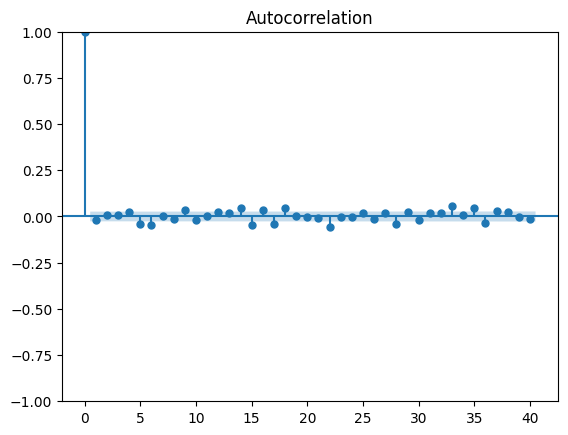

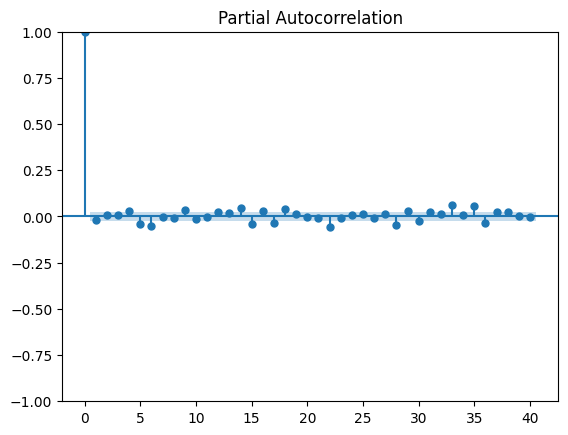

In [37]:
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
fig = sm.graphics.tsa.plot_acf(diff,lags=40)
fig = sm.graphics.tsa.plot_pacf(diff,lags=40)

In [39]:
import warnings
warnings.filterwarnings('ignore')

**Modelling (AR,MA,ARIMA,SARIMA)**

**AR**

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

# Fit the model
model = ARIMA(df['Close'], order=(6, 0, 0))
model_fit = model.fit()

# Forecast on full data
pred = model_fit.predict(start=0, end=len(df)-1)

# Evaluate on Train-Test split
train_size = int(len(df)*0.8)
train_true = df['Close'][:train_size]
test_true = df['Close'][train_size:]

train_pred = pred[:train_size]
test_pred = pred[train_size:]

# Calculate R² scores
print("Train R²:", r2_score(train_true, train_pred))
print("Test R²:", r2_score(test_true, test_pred))


Train R²: 0.9987163327468699
Test R²: 0.9908798219943765


**MA Modelling**

In [46]:
#Modelling
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

# Fit the model
model = ARIMA(df['Close'], order=(0, 0, 6))
model_fit = model.fit()

# Forecast on full data
pred = model_fit.predict(start=0, end=len(df)-1)

# Evaluate on Train-Test split
train_size = int(len(df)*0.8)
train_true = df['Close'][:train_size]
test_true = df['Close'][train_size:]

train_pred = pred[:train_size]
test_pred = pred[train_size:]

# Calculate R² scores
print("Train R²:", r2_score(train_true, train_pred))
print("Test R²:", r2_score(test_true, test_pred))


Train R²: -598697278620932.6
Test R²: -2206158475411795.8


**ARIMA Modelling**

In [49]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

# Fit the model
model = ARIMA(df['Close'], order=(6, 1, 6))
model_fit = model.fit()

# Forecast on full data
pred = model_fit.predict(start=0, end=len(df)-1)

# Evaluate on Train-Test split
train_size = int(len(df)*0.8)
train_true = df['Close'][:train_size]
test_true = df['Close'][train_size:]

train_pred = pred[:train_size]
test_pred = pred[train_size:]

# Calculate R² scores
print("Train R²:", r2_score(train_true, train_pred))
print("Test R²:", r2_score(test_true, test_pred))


Train R²: 0.9991312854923318
Test R²: 0.9910538180928161


**Future Forecast (Next 30 Days)**

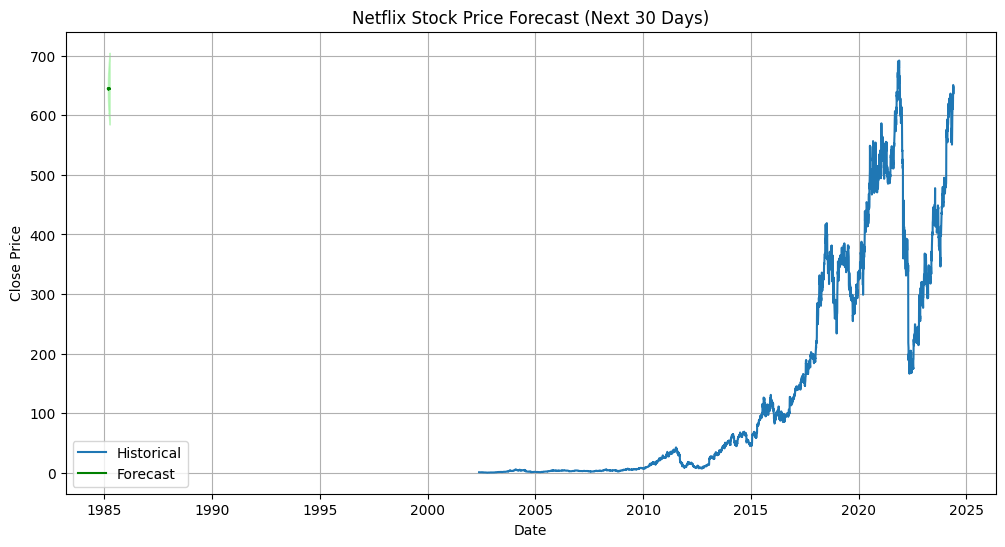

In [52]:
# Forecast next 30 days
future_forecast = model_fit.get_forecast(steps=30)
forecast_mean = future_forecast.predicted_mean
confidence_intervals = future_forecast.conf_int()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Historical')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_mean.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='lightgreen', alpha=0.5)
plt.title("Netflix Stock Price Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [54]:
# save_data.py
import pandas as pd
import joblib



# Save to joblib file
joblib.dump(df, "netflix_stock.joblib")
print("Joblib file saved as netflix_stock.joblib")


Joblib file saved as netflix_stock.joblib




## ✅ Final Summary & Insights

- We analyzed Netflix stock price trends using AR, MA, and ARIMA models.
- After evaluating model performance, **ARIMA(6,1,6)** gave the **best results** with:
  - **Train R²:** 0.9991  
  - **Test R²:** 0.9911
- We ensured stationarity using differencing and verified it with the Augmented Dickey-Fuller test.
- A 30-day forecast was generated using the ARIMA model and visualized to show expected stock movement.

### 📌 Business Insight:
The ARIMA model provides a highly accurate short-term forecast of Netflix stock prices.  
It can help investors and analysts understand potential price movement based on historical trends, offering a **data-driven tool for decision-making**.

> Note: Forecasts assume stable market conditions — unexpected news or events may cause deviation.
